In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
try:
  from helpers import get_model_size
except ModuleNotFoundError:
  import sys
  sys.path.append("../")
  from helpers import get_model_size

In [ ]:
# we actually just need it to download cifar dataset
torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

In [2]:
class CiFaData(Dataset):
  def __init__(self, stage="train", transform=None, device="cpu"):
    self.device = device
    self.base_folder = "cifar-10-batches-py"
    self.transform = transform
    if stage == "train":
      batch_collection = [f"data_batch_{i}" for i in range(1, 5)]
    elif stage == "val":
      batch_collection = ["data_batch_5"]
    elif stage == "test":
      batch_collection = ["test_batch"]
    else:
      raise ValueError("Invalid stage, choose from train, val, test.")
    self.x_data = []
    self.y_data = []
    for batch in batch_collection:
      with open(f"../data/cifar-10-batches-py/{batch}", "rb") as f:
        data = pickle.load(f, encoding="latin1") 
        self.x_data.extend(data["data"])
        self.y_data.extend(data["labels"])
    self.y_data = torch.tensor(self.y_data)
    self.x_data = np.vstack(self.x_data).reshape(-1, 3, 32, 32) # from list to np stack; results in (N, 3, 32, 32)
    self.x_data = self.x_data.transpose((0, 2, 3, 1)) # into (N, H, W, C)
  def __len__(self):
    return len(self.y_data)
  def __getitem__(self, idx):
    if self.transform:
      return self.transform(self.x_data[idx]), self.y_data[idx]
    return transforms.ToTensor()(self.x_data[idx]).to(self.device), self.y_data[idx].to(self.device)

In [8]:
tf = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = CiFaData(stage="train", device=device)
val_ds = CiFaData(stage="val", device=device)
test_ds = CiFaData(stage="test", device=device)

In [9]:
# pinning memory, takes cpu data and pins it to the gpu. meaning if I already 
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True) 
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
# using the Sequential container
class LittleConvSeq(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
    nn.Conv2d(3,6,5), # out: (B, 6, 28, 28)
    nn.ReLU(),
    nn.MaxPool2d(2,2), # (B, 6, 14, 14)
    nn.Flatten(1),
    nn.Linear(6 *14*14, 10) # (B, 10)
    )
  def forward(self, x):
    # x = F.relu(self.conv1(x))
    # x = self.pool(x)
    # x = self.fc1(torch.flatten(x,1))
    return self.net(x)

In [ ]:
# without using the Sequential container
class LittleConv(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5) # out: (B, 6, 28, 28)
    self.pool = nn.MaxPool2d(2,2) # (B, 6, 14, 14)
    self.fc1 = nn.Linear(6 *14*14, 10) # (B, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.fc1(torch.flatten(x,1))
    return x

In [ ]:
# with cuda: bs32 - 2.44s; bs64 - 2.47; bs128 - 2.31s

epochs = 20

littleconv = LittleConv()
optimimizer = optim.SGD(lr=0.001, params=littleconv.parameters(), momentum=0.9)
criterion = nn.CrossEntropyLoss()
littleconv.to('cuda')

for i in (t:= trange(epochs)):
  for x, y in cuda_loader:
    optimimizer.zero_grad()
    pred = littleconv(x)  
    loss = criterion(pred, y)
    loss.backward()
    optimimizer.step()

  t.set_description(f"epoch {i+1}: loss: {loss.item():.4f}")
f"that took {t.format_interval(t.format_dict['elapsed'])} minutes"

In [ ]:
# cpu: bs 32 - 1.76s; bs64 - 1.42; bs128 - 1.28s

epochs = 20

littleconv = LittleConv()
optimimizer = optim.SGD(lr=0.001, params=littleconv.parameters(), momentum=0.9)
criterion = nn.CrossEntropyLoss()
littleconv.to('cpu')

for i in (t:= trange(epochs)):
  for x, y in cpu_loader:
    optimimizer.zero_grad()
    pred = littleconv(x)  
    loss = criterion(pred, y)
    loss.backward()
    optimimizer.step()

  t.set_description(f"epoch {i+1}: loss: {loss.item():.4f}")
f"that took {t.format_interval(t.format_dict['elapsed'])} minutes"

In [ ]:
# example net

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
epochs = 20

net.to('cpu')

# littleconv = LittleConv()
optimimizer = optim.SGD(lr=0.001, params=net.parameters(), momentum=0.9)
criterion = nn.CrossEntropyLoss()

for i in (t:= trange(epochs)):
  for x, y in cpu_loader:
    optimimizer.zero_grad()
    pred = net(x)  
    loss = criterion(pred, y)
    loss.backward()
    optimimizer.step()

  t.set_description(f"epoch {i+1}: loss: {loss.item():.4f}")

In [ ]:
epochs = 20

net.to('cuda')

# littleconv = LittleConv()
optimimizer = optim.SGD(lr=0.001, params=net.parameters(), momentum=0.9)
criterion = nn.CrossEntropyLoss()

for i in (t:= trange(epochs)):
  for x, y in cuda_loader:
    optimimizer.zero_grad()
    pred = net(x)  
    loss = criterion(pred, y)
    loss.backward()
    optimimizer.step()

  t.set_description(f"epoch {i+1}: loss: {loss.item():.4f}")

ResNet 18

In [16]:
class ResNet18(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.block0 = nn.Sequential(
      nn.Conv2d(in_channels=3, kernel_size=7, out_channels=64, stride=2, padding=3), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.block1_1 = nn.Sequential(
      nn.Conv2d(in_channels=64, kernel_size=3, out_channels=64, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, kernel_size=3, out_channels=64, stride=1, padding=1)
    )
    self.block1_2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
    )
    self.block2_1 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
    )
    self.block2_2 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
    )
    self.block3_1 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
    )
    self.block3_2 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
    )
    self.block4_1 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
    )
    self.block4_2 = nn.Sequential(
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
    )
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    # introduction block
    x = self.block0(x) # (128, 64, 8, 8)
    # Block 1
    x_skip = x # determine the skip-x
    x = self.block1_1(x) # (128, 64, 8, 8)
    # project the output onto the skip and apply activation
    x = F.relu(x+x_skip) # (128,64,8,8)
    x_skip = x # (128,64,8,8)
    x = self.block1_2(x) # (128,64,8,8)
    x = F.relu(x+x_skip) # (128,64,8,8)
    # Block 2 
    # match dimensions
    x_skip = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, device=self.device)(x) # (128,128,4,4)
    # x_skip = x # (128,64,8,8)
    x = self.block2_1(x) # (128,128,4,4)
    x = F.relu(x+x_skip) # (128,128,4,4))
    x_skip = x # (128,128,4,4)
    x = self.block2_2(x) # (128,128,4,4)
    x = F.relu(x+x_skip) # (128,128,4,4)
    # Block3
    # match dimensions
    x_skip = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, device=self.device)(x) # (128,512,2,2)
    x = self.block3_1(x) # (128,256,2,2)
    x = F.relu(x+x_skip) 
    x_skip = x # (128,256,2,2)
    x = self.block3_2(x) # (128,256,2,2))
    x = F.relu(x+x_skip) # (128,256,2,2))
    # Block4
    x_skip = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2, device=self.device)(x) # (128,512,1,1)
    x = self.block4_1(x) # (128,512,1,1)
    x = F.relu(x+x_skip) 
    x_skip = x # (128,512,1,1)
    x = self.block4_2(x) # (128,512,1,1)
    x = F.relu(x+x_skip) # (128,512,1,1)
    # end of resing
    x = self.avg_pool(x) # (128,512,1,1)
    x = torch.flatten(x, 1) # (128,512)
    x = self.fc(x) # (128,10)
    return x

In [ ]:
device

In [20]:
epochs = 40

res18 = ResNet18(device=device)
res18.to(device)

optimizer = optim.SGD(params=[p for p in res18.parameters() if p.requires_grad == True], lr=0.001)
criterion = nn.CrossEntropyLoss()

model_size = get_model_size(res18)

model size: 41.977MB


In [25]:
# training loop
losses = []

for i in (t:=trange(epochs)):
  for step, (x, y) in enumerate(train_loader):
    predictions = res18(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  # only one per iteration
  losses.append(loss.item())
  t.set_description(f"epoch {i+1} training loss: {loss.item()}")


epoch 40 training loss: 2.302405834197998: 100%|██████████| 40/40 [02:19<00:00,  3.48s/it] 


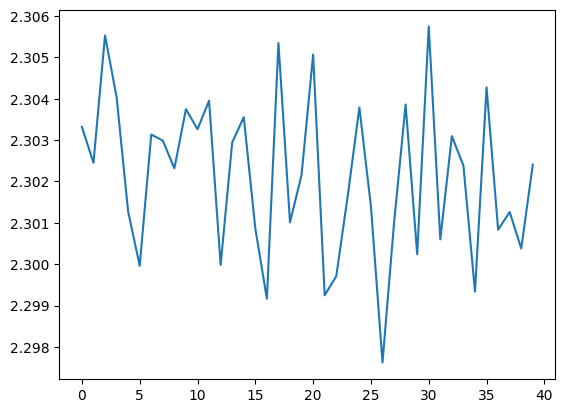

In [27]:
plt.figure()
plt.plot(range(epochs), losses)
plt.show()